In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


import cupy as cp

In [2]:
def clean_input(text_to_clean):
    text_to_clean = text_to_clean.lower()
    text_to_clean = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text_to_clean)
    text_to_clean = re.sub(r'[0-9]+', 'number', text_to_clean)
    text_to_clean = re.sub(r'[^a-zA-Z\u0621-\u064A\s]', '', text_to_clean)
    text_to_clean = re.sub(r'numbernumber+', 'number', text_to_clean)
    return text_to_clean

In [3]:
train=pd.read_csv('Dataset/train.csv')
train_Rami=pd.read_csv('Dataset/train.csv')
test=pd.read_csv('Dataset/test.csv')
y_test=pd.read_csv('Dataset/submit.csv')

In [4]:
#Initializ y_train and x_train
train['text_merge'] = 'title ' + train['title'].astype(str) + ' auther ' + train['author'].astype(str) + ' text ' + train['text'].astype(str)
x_train = train['text_merge']
y_train = train.drop(['id','title','author','text','text_merge'],axis=1)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)


(20800,)
(20800, 1)


In [5]:
#Initializ y_test and x_test
test['text_merge'] ='title ' + test['title'].astype(str) + ' auther ' + test['author'].astype(str) + ' text ' + test['text'].astype(str)
x_test = test['text_merge']
y_test = y_test.drop(['id'],axis=1)
y_test = np.array(y_test)
x_test.shape

(5200,)

In [6]:
for i in range(x_train.shape[0]):
    x_train.values[i] = clean_input(x_train[i])
    if i < 5200 :
        x_test.values[i] = clean_input(x_test[i])

In [7]:
# Get max length of sequence 
x_test.head()

0    title specter of trump loosens tongues if not ...
1    title russian warships ready to strike terrori...
2    title nodapl native american leaders vow to st...
3    title tim tebow will attempt another comeback ...
4    title keiser report meme wars enumber auther t...
Name: text_merge, dtype: object

In [8]:
# x_train_list = x_train.tolist()
tokenizer=Tokenizer(num_words= 10000, oov_token="<OOV>" )
tokenizer.fit_on_texts(x_train)
word_index=tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(sequences_train,maxlen=2000,truncating='post',padding='post')
sequences_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(sequences_test,maxlen=2000,padding='post',truncating='post')
# print(sequences_test)
# print(word_index)
print(X_train.shape)
print()
print(X_train)
print()
print(X_test.shape )
print()
print(X_test)

(20800, 2000)

[[  80  130 4989 ...    0    0    0]
 [  80 2359  111 ...    0    0    0]
 [  80  186    2 ...    0    0    0]
 ...
 [  80 9545   10 ...    0    0    0]
 [  80 1057  173 ...    0    0    0]
 [  80   56 3164 ...    0    0    0]]

(5200, 2000)

[[  80    1    4 ...    0    0    0]
 [  80  228 8902 ...    0    0    0]
 [  80    1 1640 ...    0    0    0]
 ...
 [  80  492  295 ...    0    0    0]
 [  80    9   63 ...    0    0    0]
 [  80 6504 1081 ...    0    0    0]]


activation function (sigmoid)

In [9]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

derivative of the activation function
 . minimize the error 

In [10]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1- sigmoid(x))

# Neural Network class

In [11]:

# accuracy = [[1,2,3,4,5,6,7]]
class NeuralNetworkCPU:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.weights1 = np.random.randn(input_size, hidden_size1)
        self.weights2 = np.random.randn(hidden_size1, hidden_size2)
        self.weights3 = np.random.randn(hidden_size2, output_size)
        self.Accuracy = []
        self.Loss = []
        self.epo = 0

    def forward(self, X):
        self.hidden1 = np.dot(X, self.weights1)
        self.hidden_activation1 = sigmoid(self.hidden1)
        self.hidden2 = np.dot(self.hidden_activation1, self.weights2)
        self.hidden_activation2 = sigmoid(self.hidden2)
        self.output = np.dot(self.hidden_activation2, self.weights3)
        return sigmoid(self.output)

    def train(self, X, y, epochs, lambda_val):
        for epoch in range(epochs):
            self.epo += 1 
            # Forward propagation
            output = self.forward(X)
            
            # Backpropagation
            error = y - output
            delta_output = error * sigmoid_derivative(output)
            delta_hidden2 = np.dot(delta_output, self.weights3.T) * sigmoid_derivative(self.hidden_activation2)
            delta_hidden1 = np.dot(delta_hidden2, self.weights2.T) * sigmoid_derivative(self.hidden_activation1)
            
            # Update weights using Levenberg-Marquardt algorithm
            J = np.dot(self.hidden_activation2.T, delta_output)
            H = np.dot(self.hidden_activation2.T, self.hidden_activation2)
            H = H + lambda_val * np.identity(self.hidden_size2)
            self.weights3 = self.weights3 +  np.dot(J.T, np.linalg.inv(H)).T
            
            J = np.dot(self.hidden_activation1.T, delta_hidden2)
            H = np.dot(self.hidden_activation1.T, self.hidden_activation1)
            H = H + lambda_val * np.identity(self.hidden_size1)
            self.weights2 = self.weights2 +  np.dot(J.T, np.linalg.inv(H)).T
            
            
            J = np.dot(X.T, delta_hidden1)
            H = np.dot(X.T, X )
            H = H + lambda_val * np.identity(self.input_size).astype(float)
            self.weights1 = self.weights1 +  np.dot(J.T, np.linalg.inv(H)).T
            
            # Calculate loss and accuracy
            loss = np.mean(np.square(error))
            y_pred = self.predict(X)
            accuracy = np.mean(y == y_pred)
            
            self.Accuracy.append(accuracy)
            self.Loss.append(loss)
            
            # Print epoch details
            print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")

    def predict(self, X):
        return np.round(self.forward(X)) 

In [29]:
# import cupy as cp

class NeuralNetworkGPU:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.weights1 = cp.random.randn(input_size + 1 , hidden_size1)
        self.weights2 = cp.random.randn(hidden_size1 + 1, hidden_size2)
        self.weights3 = cp.random.randn(hidden_size2 + 1, output_size)
        self.Accuracy = []
        self.Loss = []
        self.epo = 0
        self.m = 1
        
    def forward(self, X):
        X = cp.hstack((X, cp.ones((X.shape[0], 1)))) 
        self.hidden1 = cp.dot(X, self.weights1)
        self.hidden_activation1 = sigmoid(self.hidden1)
        self.hidden_activation1 = cp.hstack((self.hidden_activation1, cp.ones((X.shape[0], 1))))
        self.hidden2 = cp.dot(self.hidden_activation1, self.weights2)
        self.hidden_activation2 = sigmoid(self.hidden2)
        self.hidden_activation2 = cp.hstack((self.hidden_activation2, cp.ones((X.shape[0], 1)))) 
        self.output = cp.dot(self.hidden_activation2, self.weights3)
        return sigmoid(self.output)
    
    
    def train(self, X, y, epochs, lambda_val):
        X = cp.asarray(X)
        y = cp.asarray(y)
        for epoch in range(epochs):
            self.epo += 1 
            # Forward propagation 
            output = self.forward(X)
            
            # Backpropagation
            # error = self.binary_crossentropy_derivative(y_pred= output , y_true= y)
            error = 2* (y - output)
            delta_output =  error * sigmoid_derivative(output) 
            delta_hidden2 = cp.dot(delta_output, self.weights3[:-1].T) * sigmoid_derivative(self.hidden_activation2[:, :-1]) 
            delta_hidden1 = cp.dot(delta_hidden2, self.weights2[:-1].T) * sigmoid_derivative(self.hidden_activation1[: , :-1])
            
            
            # Update weights using Levenberg-Marquardt algorithm  
            J1 = cp.dot(self.hidden_activation2.T, delta_output) 
            H1 = cp.dot(self.hidden_activation2.T, self.hidden_activation2) 
            H1 = H1 + (lambda_val * cp.identity(self.hidden_size2 + 1)) 
            self.weights3 = self.weights3 +   cp.dot(J1.T, cp.linalg.inv(H1)).T
            
            J2 = cp.dot(self.hidden_activation1.T, delta_hidden2)
            H2 = cp.dot(self.hidden_activation1.T, self.hidden_activation1)
            H2 = H2 + (lambda_val * cp.identity(self.hidden_size1 + 1))
            self.weights2 = self.weights2 +   cp.dot(J2.T, cp.linalg.inv(H2)).T
            
            J3 = cp.dot(X.T, delta_hidden1)
            H3 = cp.dot(X.T, X) 
            H3 = H3+ (lambda_val * cp.identity(self.input_size + 1)[:-1 , :-1].astype(float))
            self.weights1[:-1] +=  cp.dot(J3.T, cp.linalg.inv(H3)).T
            
            
            # Calculate loss and accuracy
            loss = cp.mean(cp.square(y - output))
            y_pred = self.predict(X)
            accuracy = cp.mean(y == y_pred)
            
            self.Accuracy.append(accuracy)
            self.Loss.append(loss) 
            
            #  change lamda debent on the LOSS
            if len(self.Loss) > 1:
                i = len(self.Loss) - 1
                if self.Loss[i] <= self.Loss[i - 1]:
                    lambda_val *= 0.9  # Decrease lambda by a factor (e.g., 0.9) for descent
                else : 
                    # Estimate the curvature of the loss function
                    loss_change_ratio = (self.Loss[i] - self.Loss[i - 1]) / self.Loss[i - 1]
                    lambda_val *= 1 + abs(loss_change_ratio)  # Increase lambda based on curvature
                    
            # Print epoch details
            print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy} \n lamda: {lambda_val}")
        
    def predict(self, X):
        return cp.round(self.forward(X))

try the NN 

In [30]:
X_train.shape[1]

2000

In [35]:
# Create an instance of the neural network
input_size = X_train.shape[1]
hidden_size = 512
sec_hidden_size = 256
output_size = 1
nn = NeuralNetworkGPU(input_size, hidden_size, sec_hidden_size  ,output_size)

In [37]:
# Train the neural network using Levenberg-Marquardt algorithm
epochs = 200
lambda_val = 0.01
nn.train(X_train, y_train, epochs, lambda_val)

Epoch: 0, Loss: 0.22013658061706673, Accuracy: 0.6418269230769231 
 lamda: 5.3854722595086814e-08
Epoch: 1, Loss: 0.22011819043195172, Accuracy: 0.6417788461538462 
 lamda: 4.846925033557813e-08
Epoch: 2, Loss: 0.2200997552492049, Accuracy: 0.641875 
 lamda: 4.362232530202032e-08
Epoch: 3, Loss: 0.22008125612746496, Accuracy: 0.6419230769230769 
 lamda: 3.9260092771818286e-08
Epoch: 4, Loss: 0.22006254400657937, Accuracy: 0.6420192307692307 
 lamda: 3.533408349463646e-08
Epoch: 5, Loss: 0.22004397865400951, Accuracy: 0.641875 
 lamda: 3.180067514517281e-08
Epoch: 6, Loss: 0.2200265879562198, Accuracy: 0.6416826923076923 
 lamda: 2.862060763065553e-08
Epoch: 7, Loss: 0.22001002387661173, Accuracy: 0.6418269230769231 
 lamda: 2.5758546867589977e-08
Epoch: 8, Loss: 0.21999431382684778, Accuracy: 0.6417307692307692 
 lamda: 2.318269218083098e-08
Epoch: 9, Loss: 0.21997857718210828, Accuracy: 0.6417788461538462 
 lamda: 2.086442296274788e-08
Epoch: 10, Loss: 0.21996186943573048, Accuracy: 0

# draw 

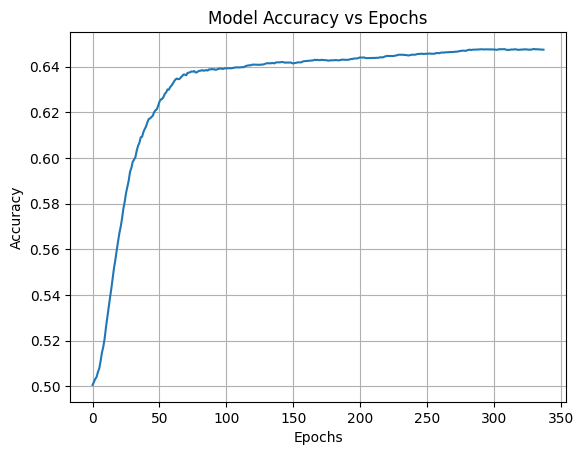

In [38]:
# acc = np.array([nn.Accuracy])
epoch = range(nn.epo )
epochs = cp.asarray(epoch).get()
acc = cp.asarray(nn.Accuracy).get()
plt.plot(epochs, acc)
plt.title('Model Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

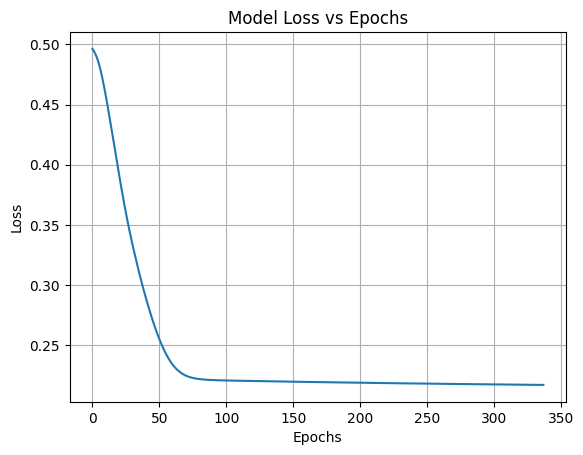

In [39]:
epoch = range(nn.epo )
epochs = cp.asarray(epoch).get()
loss = cp.asarray(nn.Loss).get()
plt.plot(epochs, loss)
plt.title('Model Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# test

In [40]:
# Make predictions on the testing set
X = cp.asarray(X_test)
y_pred = nn.predict(X)
y_pred

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

accuracy 

In [41]:
# Calculate the accuracy of the model
Y = cp.asarray(y_test).get()
Y_p = cp.asarray(y_pred).get()
accuracy = accuracy_score(Y, Y_p)
print("Accuracy:", accuracy)

Accuracy: 0.749423076923077
